<a href="https://colab.research.google.com/github/ssyss-513/MyColab/blob/main/COMP5511/5511_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 2.4 MB/s eta 0:00:00


In [2]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

# DEAP imports
from deap import base, creator, tools, algorithms
import deap.creator as deap_creator  # to allow deletion of pre-created classes


In [3]:
# ---------------------------
# Helper: safely (re)create DEAP creator classes
# ---------------------------
def reset_deap_creator(fitness_name="FitnessMin", ind_name="Individual"):
    for name in (fitness_name, ind_name):
        if hasattr(deap_creator, name):
            try:
                delattr(deap_creator, name)
            except Exception:
                pass

reset_deap_creator()


In [31]:
# ---------------------------
# Load VRP.csv
# ---------------------------
csv_path = "VRP.csv"
df = pd.read_csv(csv_path, dtype=str)

# Normalize and decide columns
if "NO" in df.columns and any(c.upper().find("CUST") >= 0 for c in df.columns if isinstance(c, str)):
    # try to map standard column names
    cols = {c.upper(): c for c in df.columns}
    col_type = None
    for candidate in ["CUST OR DEPOT", "TYPE", "CUST_OR_DEPOT", "CUST/DEPOT"]:
        if candidate in cols:
            col_type = cols[candidate]
            break
    if col_type is None:
        col_type = df.columns[0]
    col_no = cols.get("NO", df.columns[1] if len(df.columns) > 1 else df.columns[0])
    candidate_coords = [c for c in df.columns if any(x in c.upper() for x in ["X", "LONG", "COORD", "LAT", "Y"])]
    col_x = candidate_coords[0] if len(candidate_coords) >= 1 else df.columns[2]
    col_y = candidate_coords[1] if len(candidate_coords) >= 2 else df.columns[3]
    col_demand = next((c for c in df.columns if "DEMAND" in c.upper()), df.columns[-1])
    df = df.rename(columns={col_type: "TYPE", col_no: "NO", col_x: "XCOORD", col_y: "YCOORD", col_demand: "DEMAND"})
else:
    # fallback: no header
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 5:
        raise ValueError("VRP.csv seems to have fewer than 5 columns.")
    df = df.rename(columns={0: "TYPE", 1: "NO", 2: "XCOORD", 3: "YCOORD", 4: "DEMAND"})

# Convert dtypes
df["TYPE"] = df["TYPE"].astype(str).str.strip()
df["NO"] = df["NO"].astype(int)
df["XCOORD"] = pd.to_numeric(df["XCOORD"])
df["YCOORD"] = pd.to_numeric(df["YCOORD"])
df["DEMAND"] = pd.to_numeric(df["DEMAND"])


In [32]:
df.head(10)

,TYPE,NO,XCOORD,YCOORD,DEMAND,EFFICIENCY
0,DEPOT,0,20.00,20.00,0,0.0
1,DEPOT,1,80.00,20.00,0,0.0
2,DEPOT,2,50.00,50.00,0,0.0
3,DEPOT,3,20.00,80.00,0,0.0
4,DEPOT,4,80.00,80.00,0,0.0
5,CUSTOMER,5,63.94,2.50,9,70.93
6,CUSTOMER,6,10.25,74.07,18,54.77
7,CUSTOMER,7,9.37,23.27,20,79.83
8,CUSTOMER,8,64.99,54.49,8,91.73
9,CUSTOMER,9,86.93,75.88,6,101.04


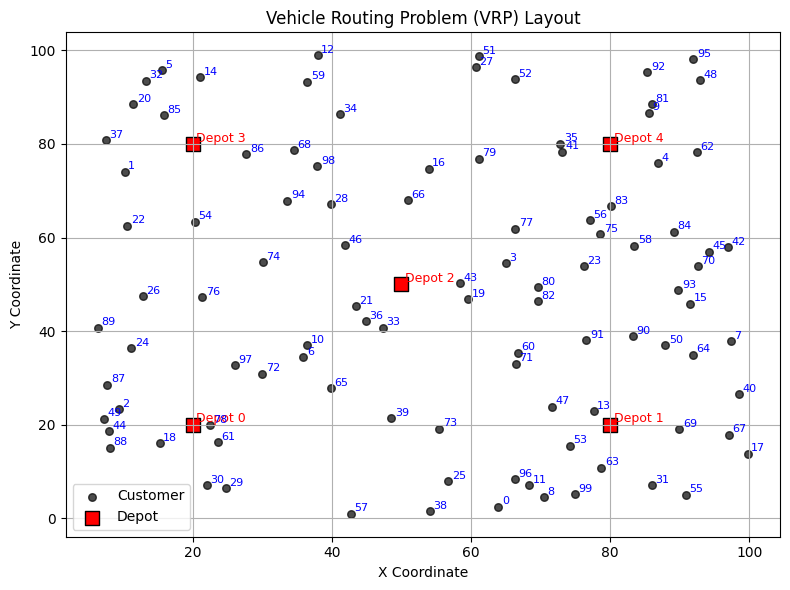

In [24]:
import matplotlib.pyplot as plt

# 分离仓库和客户
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")]

plt.figure(figsize=(8, 6))

# 绘制客户点
plt.scatter(customers["XCOORD"], customers["YCOORD"],
            c='black', label='Customer', s=30, alpha=0.7)

# 绘制仓库点（红色方块）
plt.scatter(depots["XCOORD"], depots["YCOORD"],
            c='red', marker='s', label='Depot', s=100, edgecolors='black')

# 添加标注
for _, row in depots.iterrows():
    plt.text(row["XCOORD"]+0.5, row["YCOORD"]+0.5, f'Depot {int(row["NO"])}', color='red', fontsize=9)
for _, row in customers.iterrows():
    plt.text(row["XCOORD"]+0.5, row["YCOORD"]+0.5, str(int(row["NO"]-5)), color='blue', fontsize=8)

# 美化图形
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Vehicle Routing Problem (VRP) Layout")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        105 non-null    object 
 1   NO          105 non-null    int64  
 2   XCOORD      105 non-null    float64
 3   YCOORD      105 non-null    float64
 4   DEMAND      105 non-null    int64  
 5   EFFICIENCY  105 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.1+ KB


In [7]:
# ---------------------------
# Before Q3 Build coordinates and demands dicts, identify depot and customers
# ---------------------------
if ((df["TYPE"].str.upper() == "DEPOT") & (df["NO"] == 0)).any():
    depot_row = df[(df["TYPE"].str.upper() == "DEPOT") & (df["NO"] == 0)].iloc[0]
else:
    depot_rows = df[df["TYPE"].str.upper() == "DEPOT"]
    if len(depot_rows) == 0:
        raise ValueError("No depot row found in VRP.csv")
    depot_row = depot_rows.iloc[0]

depot_coords = (float(depot_row["XCOORD"]), float(depot_row["YCOORD"]))
depot_no = int(depot_row["NO"])

customers_df = df[df["TYPE"].str.upper().str.contains("CUST|CUSTOMER", na=False)]
if customers_df.empty:
    customers_df = df[df["NO"] != depot_no]

customer_id_list = list(customers_df["NO"].astype(int).tolist())
idx_to_cust = customer_id_list[:]
cust_to_idx = {cust_id: i for i, cust_id in enumerate(idx_to_cust)}

coords = {}
demands = {}
for _, row in customers_df.iterrows():
    cid = int(row["NO"])
    coords[cid] = (float(row["XCOORD"]), float(row["YCOORD"]))
    demands[cid] = float(row["DEMAND"])
coords[depot_no] = depot_coords
demands[depot_no] = 0.0

CAPACITY = 200.0


In [8]:
# Utility: Euclidean distance

def distance(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])


In [16]:
# DEAP setup

reset_deap_creator()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

n_customers = len(idx_to_cust)
if n_customers == 0:
    raise ValueError("No customers detected in VRP.csv.")

toolbox.register("indices", random.sample, range(n_customers), n_customers)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("select", tools.selTournament, tournsize=3)



In [49]:
# ==============================
# Q1: Classical VRP (Robust version)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import random

# -----------------------------
# 1. Load VRP.csv (auto-detect header and columns)
# -----------------------------
csv_path = "VRP.csv"

df_try = pd.read_csv(csv_path, nrows=1)
first_row = df_try.columns.tolist()
has_header = any(any(ch.isalpha() for ch in str(x)) for x in first_row)
df = pd.read_csv(csv_path, header=0 if has_header else None, dtype=str)

# 标准化列名
df.columns = [str(c).strip().upper() for c in df.columns]

# 判断是否有 TYPE 信息
if not any("CUST" in c or "DEPOT" in str(df.iloc[0,0]).upper() for c in df.columns):
    # 没有明确TYPE列，则假定第1列是TYPE，第2列是编号
    if df.shape[1] >= 5:
        df.columns = ["CUST_OR_DEPOT","NO","XCOORD","YCOORD","DEMAND"]
    else:
        raise ValueError("VRP.csv 格式异常，请检查列数是否至少5列。")

# 处理列名匹配
rename_map = {}
for c in df.columns:
    if "CUST" in c or "TYPE" in c:
        rename_map[c] = "TYPE"
    elif "NO" in c:
        rename_map[c] = "NO"
    elif "DEMAND" in c:
        rename_map[c] = "DEMAND"
df = df.rename(columns=rename_map)

# 类型转换
df["TYPE"] = df["TYPE"].astype(str).str.strip()
df["NO"] = df["NO"].astype(int)
df["XCOORD"] = pd.to_numeric(df["XCOORD"])
print(df.columns)

df["YCOORD"] = pd.to_numeric(df["YCOORD"])
df["DEMAND"] = pd.to_numeric(df["DEMAND"])

# -----------------------------
# 2. Split depot and customers
# -----------------------------
depot_row = df[df["TYPE"].str.upper().str.contains("DEPOT")].iloc[0]
depot_no = int(depot_row["NO"])
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()

coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
CAPACITY = 200

idx_to_cust = list(customers["NO"])

# -----------------------------
# 3. Distance matrix
# -----------------------------
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    n = len(nodes)
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# -----------------------------
# 4. Evaluation function
# -----------------------------
def eval_vrp_classical(individual):
    PENALTY = 1e7
    total_dist = 0.0
    load = 0.0
    cur = depot_no
    segments = []
    seg = [depot_no]

    for idx in individual:
        cust = idx_to_cust[idx]
        load += demands[cust]
        if load > CAPACITY:  # 超载回仓
            total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
            segments.append(seg + [depot_no])
            seg = [depot_no]
            load = demands[cust]
            cur = depot_no
        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust

    total_dist += dist_matrix[node_to_index[cur], node_to_index[depot_no]]
    seg.append(depot_no)
    segments.append(seg)

    return (total_dist,), segments

# -----------------------------
# 5. GA setup
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate_only(ind):
    val, _ = eval_vrp_classical(ind)
    return val

toolbox.register("evaluate", evaluate_only)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)



Index(['TYPE', 'NO', 'XCOORD', 'YCOORD', 'DEMAND', 'EFFICIENCY'], dtype='object')


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
# -----------------------------
# 6. Run GA
# -----------------------------
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.25, ngen=5800,
                    stats=stats, halloffame=hof, verbose=True)

best = hof[0]
best_val, best_segments = eval_vrp_classical(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(depot_row["XCOORD"], depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]

        # 判断路线类型
        if seg[j] == depot_no or seg[j+1] == depot_no:
            # depot 到客户 或客户回 depot
            plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='--')
        else:
            # 客户到客户
            plt.plot([x1, x2], [y1, y2], color=colors[i], lw=2, linestyle='-')

    # 标记每次行程
    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# 添加图例，说明虚线和实线
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Depot → Customer / Customer → Depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()


0 [1, 2, 3, 4]
✅ 读取了 0 个历史最优解
gen	nevals	avg    	min    	max    
0  	100   	5410.43	4868.49	5883.49
1  	80    	5264.12	4701.22	5686.21
2  	76    	5171.52	4611.13	5764.25
3  	81    	5069.74	4572.93	5647.1 
4  	82    	4993.51	4572.93	5473.64
5  	78    	4908.49	4488.7 	5334.27
6  	84    	4910.85	4488.7 	5482.11
7  	83    	4859.16	4467.21	5375.34
8  	89    	4819.44	4281.29	5366.63
9  	78    	4804.56	4358.5 	5269.99
10 	82    	4786.62	4356.19	5290.15
11 	69    	4721.04	4322.67	5296   
12 	80    	4651.94	4288.84	5057.3 
13 	78    	4587.8 	4208.86	5058.3 
14 	84    	4531.93	4190.83	5013.57
15 	77    	4482.23	4149.69	5097.27
16 	85    	4453.04	4023.33	5123.27
17 	78    	4397.82	4117.7 	5064.33


/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


18 	79    	4375.77	4120.31	4901.17
19 	83    	4352.37	3925.9 	4801.38
20 	79    	4325.61	4044.37	4932.39
21 	87    	4335.98	4021.69	4888.96
22 	74    	4298.44	4021.69	4714.72
23 	71    	4334.06	3966.67	4840.29
24 	77    	4321.54	3966.67	4893.03
25 	79    	4281.24	3973.38	4916.62
26 	76    	4275.99	3896.17	5115.45
27 	79    	4232.75	3938.97	4703.11
28 	71    	4223.92	3907.85	4758.97
29 	90    	4264.25	3746.59	4855.28
30 	82    	4230.77	3811.09	4810.97
31 	76    	4197.89	3770.68	4818.31
32 	75    	4153   	3792.02	4794.78
33 	77    	4148.46	3840.85	4680.51
34 	79    	4150.83	3809.19	4743.6 
35 	69    	4108.53	3784.74	4636.09
36 	73    	4109.01	3757.1 	4897.5 
37 	76    	4090.82	3757.1 	4759.96
38 	76    	4126.6 	3728.08	5183.55
39 	77    	4059.32	3757.1 	4685.87
40 	81    	4055.97	3772.2 	4710.22
41 	80    	4027.87	3761.59	4549.66
42 	78    	4041.59	3772.2 	4789.58
43 	76    	4070.51	3700.32	4756.14
44 	85    	4067.43	3700.32	4721.48
45 	73    	4051.73	3748.78	4538.23
46 	75    	4054.39	3

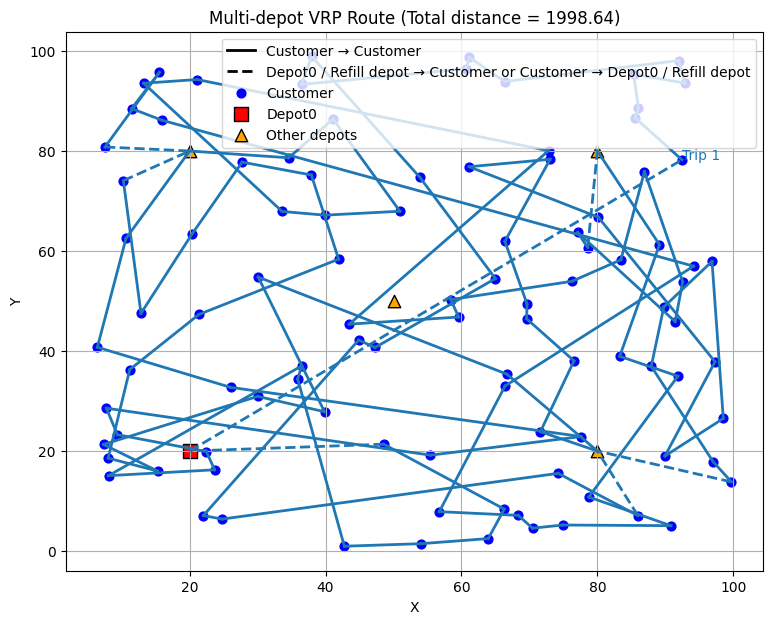

In [60]:
# ==============================
# Q1: Multi-depot VRP (Depot0 start/end, others as refill)
# ==============================

# -----------------------------
# 2. Split depot0, other depots, customers
# -----------------------------
# 所有仓库
depots = df[df["TYPE"].str.upper().str.contains("DEPOT")]
# 自行选择主仓库，例如 NO 最小的
main_depot_row = depots.iloc[depots["NO"].idxmin()]
main_depot_no = int(main_depot_row["NO"])

# 其他补货仓库
other_depots = depots[depots["NO"] != main_depot_no]
other_depot_nos = list(other_depots["NO"])

# 客户
customers = df[~df["TYPE"].str.upper().str.contains("DEPOT")].copy()
idx_to_cust = list(customers["NO"])
print(main_depot_no,other_depot_nos)

# Coordinates & demands
coords = {int(row["NO"]):(row["XCOORD"], row["YCOORD"]) for _,row in df.iterrows()}
demands = {int(row["NO"]):float(row["DEMAND"]) for _,row in df.iterrows()}
CAPACITY = 200

# -----------------------------
# 3. Distance matrix
# -----------------------------
def build_distance_matrix(coords):
    nodes = sorted(coords.keys())
    arr = np.array([coords[k] for k in nodes])
    diff = arr[:,None,:] - arr[None,:,:]
    dist = np.sqrt((diff**2).sum(axis=2))
    node_to_index = {node:i for i,node in enumerate(nodes)}
    return dist, node_to_index

dist_matrix, node_to_index = build_distance_matrix(coords)

# -----------------------------
# 4. Evaluation function with multi-depot refill
# -----------------------------
def eval_vrp_multi_depot(individual):
    total_dist = 0.0
    load = 0.0
    cur = main_depot_no
    segments = []
    seg = [main_depot_no]

    for idx in individual:
        cust = idx_to_cust[idx]
        load += demands[cust]

        # 如果超载，先去最近补货仓库
        while load > CAPACITY:
            if other_depot_nos:
                nearest_depot = min(other_depot_nos, key=lambda d: dist_matrix[node_to_index[cur], node_to_index[d]])
            else:
                nearest_depot = main_depot_no  # 没有其他仓库则回主仓库
            total_dist += dist_matrix[node_to_index[cur], node_to_index[nearest_depot]]
            seg.append(nearest_depot)
            cur = nearest_depot
            load = demands[cust]  # 补货后重新装载

        total_dist += dist_matrix[node_to_index[cur], node_to_index[cust]]
        seg.append(cust)
        cur = cust

    # 最后回主仓库
    total_dist += dist_matrix[node_to_index[cur], node_to_index[main_depot_no]]
    seg.append(main_depot_no)
    segments.append(seg)



    return (total_dist,), segments

# -----------------------------
# 5. GA setup (same as before)
# -----------------------------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(idx_to_cust)), len(idx_to_cust))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", lambda ind: eval_vrp_multi_depot(ind)[0])
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# -----------------------------
# 5. 读取历史最优解（如果存在）
# -----------------------------
try:
    with open("best_solutions.pkl", "rb") as f:
        saved_solutions = pickle.load(f)
    print(f"✅ 读取了 {len(saved_solutions)} 个历史最优解")
    # 用保存的个体初始化种群前 N 个
    initial_pop = [creator.Individual(sol["individual"]) for sol in saved_solutions]
except FileNotFoundError:
    print("⚠️ 未找到历史最优解文件，将随机初始化种群")
    initial_pop = []
# -----------------------------
# 6. Run GA
# -----------------------------

n_random = max(0, 100 - len(initial_pop))  # 剩余个体随机生成
pop = initial_pop + [toolbox.individual() for _ in range(n_random)]
hof = tools.HallOfFame(1)
hof_save = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.3, ngen=2000,
                    stats=stats, halloffame=hof, verbose=True)

best = hof[0]
best_val, best_segments = eval_vrp_multi_depot(best)
print(f"\n✅ Best distance: {best_val[0]:.2f}")

# 打印每次 trip 的路线
for i, s in enumerate(best_segments):
    print(f"Trip {i+1}: {' -> '.join(map(str,s))}")

# -----------------------------
# 7. Visualization
# -----------------------------
plt.figure(figsize=(9,7))
plt.scatter(customers["XCOORD"], customers["YCOORD"], c='blue', s=40, label="Customer")
plt.scatter(main_depot_row["XCOORD"], main_depot_row["YCOORD"], c='red', marker='s', s=100,
            edgecolors='black', label="Depot0")
plt.scatter(other_depots["XCOORD"], other_depots["YCOORD"], c='orange', marker='^', s=80,
            edgecolors='black', label="Other depots")

colors = plt.cm.tab20(np.linspace(0,1,len(best_segments)))

for i, seg in enumerate(best_segments):
    for j in range(len(seg)-1):
        x1, y1 = coords[seg[j]]
        x2, y2 = coords[seg[j+1]]
        # 虚线: depot0 或其他补货仓库
        if seg[j] == main_depot_no or seg[j+1] == main_depot_no or seg[j+1] in other_depot_nos:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2, linestyle='--')
        else:
            plt.plot([x1,x2],[y1,y2], color=colors[i], lw=2)

    plt.text(coords[seg[1]][0], coords[seg[1]][1], f"Trip {i+1}", color=colors[i])

# 图例
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0],[0], color='black', lw=2, linestyle='-', label='Customer → Customer'),
    Line2D([0],[0], color='black', lw=2, linestyle='--', label='Depot0 / Refill depot → Customer or Customer → Depot0 / Refill depot')
]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.title(f"Multi-depot VRP Route (Total distance = {best_val[0]:.2f})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()


In [61]:
import pickle

best_solutions = []
for i, ind in enumerate(hof_save):
    val, segments = eval_vrp_multi_depot(ind)
    best_solutions.append({"individual": ind, "fitness": val[0], "segments": segments})
    print(f"\nTop {i+1} distance: {val[0]:.2f}")
    for j, s in enumerate(segments):
        print(f"  Trip {j+1}: {' -> '.join(map(str,s))}")

with open("best_solutions.pkl", "wb") as f:
    pickle.dump(best_solutions, f)

print("\n✅ 前10个最优解已保存到 best_solutions.pkl")


✅ 前10个最优解已保存到 best_solutions.pkl


In [10]:
#Q1
def eval_vrp_classical(individual):
    """
    Classical deterministic VRP fitness.
    Input:
      individual: list of indices in 0..n_customers-1 (uses idx_to_cust mapping)
    Returns:
      (total_cost,)  -- one-tuple for DEAP minimization
    Notes:
      - Uses global coords, demands, depot_no, CAPACITY
      - Penalizes capacity violation by adding large constant PENALTY
    """
    PENALTY = 1e7
    total_dist = 0.0
    load = 0.0
    current = depot_no
    for idx in individual:
        cust = idx_to_cust[idx]
        total_dist += distance(coords[current], coords[cust])
        load += demands[cust]
        if load > CAPACITY + 1e-9:
            total_dist += PENALTY
        current = cust
    # return to depot
    total_dist += distance(coords[current], coords[depot_no])
    return (total_dist,)


In [18]:
#Q2

import numpy as np

def sample_demand(original_mean):
    """
    Sample truncated normal demand:
      N(mean, 0.2*mean), truncated to positive integer (>=0)
    """
    mu = original_mean
    sigma = max(1e-9, 0.2 * original_mean)  # avoid zero
    # simple truncation at 0, sample until positive
    val = -1
    while val <= 0:
        val = np.random.normal(mu, sigma)
    return int(round(val))

def eval_vrp_stochastic_singleobj(individual, M=50, PENALTY=1e6):
    """
    Stochastic-demand single-objective fitness.
    - M: number of Monte Carlo demand realizations to average over
    - PENALTY: per-infeasible-run penalty added to distance
    Returns (score,) where smaller is better.
    """
    total_score = 0.0
    feasible_count = 0
    for _ in range(M):
        # sample demands for all customers (dict)
        sampled_demands = {cid: sample_demand(demands[cid]) for cid in demands if cid != depot_no}
        # run route
        total_dist = 0.0
        load = 0.0
        current = depot_no
        infeasible = False
        for idx in individual:
            cust = idx_to_cust[idx]
            total_dist += distance(coords[current], coords[cust])
            load += sampled_demands.get(cust, 0)
            if load > CAPACITY + 1e-9:
                infeasible = True
            current = cust
        total_dist += distance(coords[current], coords[depot_no])
        if infeasible:
            total_score += (total_dist + PENALTY)
        else:
            total_score += total_dist
            feasible_count += 1
    expected_score = total_score / M
    feasibility_rate = feasible_count / M

    return (expected_score,)

toolbox.register("evaluate", eval_vrp_stochastic_singleobj)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Q3 cluster


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# 提取顾客坐标 (排除 depot)
X = np.array([[coords[cid][0], coords[cid][1]] for cid in customer_id_list])
X_shifted = X.copy()
X_shifted[:, 1] += 150
X_large = np.vstack((X, X_shifted))
# 运行 DBSCAN
db = DBSCAN(eps=15, min_samples=6).fit(X_large)   # eps: 半径阈值, min_samples: 最小邻居数

# 获取标签 (-1 表示噪声点)
labels = db.labels_

# 建立顾客ID -> 簇号的映射
cust_cluster = {cid: int(label) for cid, label in zip(customer_id_list, labels)}

print("Cluster labels:", set(labels))
print("Cluster mapping example:", list(cust_cluster.items())[:10])


Cluster labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-1)}
Cluster mapping example: [(5, 0), (6, 1), (7, 0), (8, 0), (9, 0), (10, 1), (11, 0), (12, 0), (13, 0), (14, 0)]


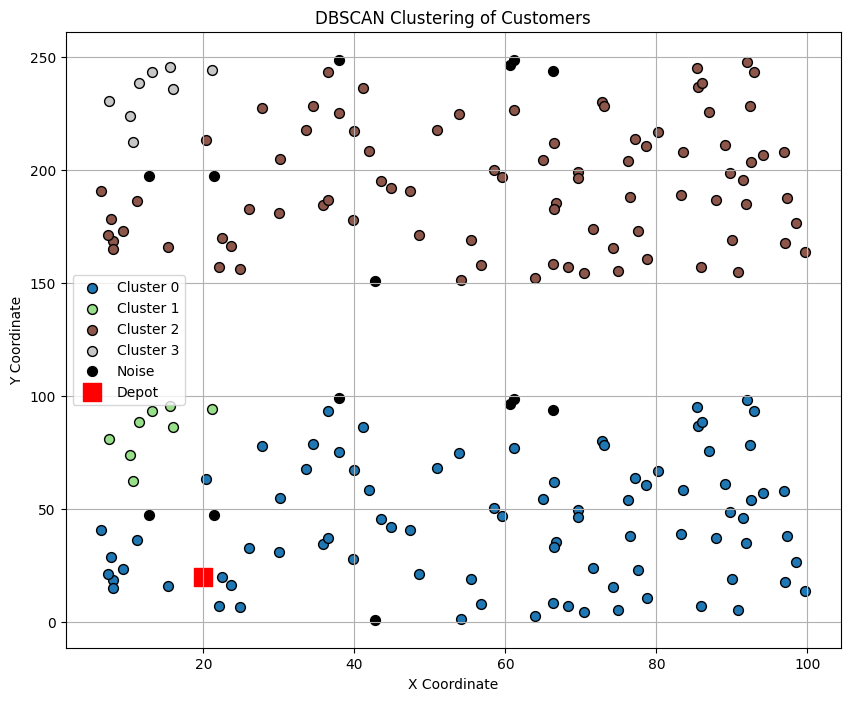

In [ ]:
import matplotlib.pyplot as plt

# 提取顾客坐标
X = np.array([[coords[cid][0], coords[cid][1]] for cid in customer_id_list])

# DBSCAN 聚类标签
# labels = db.labels_  # 你已经有了

unique_labels = set(labels)
colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # 噪声点设为黑色
        col = [0, 0, 0, 1]

    class_mask = (labels == k)
    xy = X_large[class_mask]

    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f"Cluster {k}" if k != -1 else "Noise", s=50, edgecolor='k')

# 标出 depot
plt.scatter(depot_coords[0], depot_coords[1], c='red', marker='s', s=150, label='Depot')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("DBSCAN Clustering of Customers")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Q3

def eval_vrp_with_clustering(individual, cust_cluster, PENALTY_PER_SEGMENT=1e6):
    """
    - cust_cluster: dict mapping real customer id -> cluster id
    - Penalize if a cluster is visited in multiple non-contiguous segments.
    Returns (cost,)
    """
    # compute total distance and record cluster visitation order
    total_dist = 0.0
    current = depot_no
    visit_clusters = []  # sequence of cluster ids as visited in order (for customers)
    for idx in individual:
        cust = idx_to_cust[idx]
        total_dist += distance(coords[current], coords[cust])
        visit_clusters.append(cust_cluster[cust])
        current = cust
    total_dist += distance(coords[current], coords[depot_no])

    # compute number of contiguous segments per cluster
    seen_segments = {}
    prev_cluster = None
    for cl in visit_clusters:
        if cl != prev_cluster:
            seen_segments[cl] = seen_segments.get(cl, 0) + 1
            prev_cluster = cl
    # extra segments = sum(segments - 1 for clusters with segments>1)
    extra_segments = sum(max(0, segs - 1) for segs in seen_segments.values())

    cost = total_dist + PENALTY_PER_SEGMENT * extra_segments
    return (cost,)


# Q4 MULTI-OBJECTIVE OPTIMIZATION PROBLEM

In [ ]:
#Q4-1

def eval_vrp_multi_weighted(individual, w=0.5):
    """
    Weighted single-objective: f = w * f1 - (1-w) * f2
    Return (f,) for DEAP minimization.
    Notes:
      - EFFICIENCY for each customer must be available: assume `efficiency[cid]` dict exists.
    """
    # compute f1 (total distance) and per-customer cumulative distance for f2
    total_dist = 0.0
    cumulative = 0.0
    current = depot_no
    f2_sum = 0.0
    # 确保只选顾客行，不包括 depot
    customers_df = df[df["TYPE"].str.upper().str.contains("CUST|CUSTOMER", na=False)]

    # 构造字典：key=顾客ID, value=EFFICIENCY
    efficiency = {int(row["NO"]): float(row["EFFICIENCY"]) for _, row in customers_df.iterrows()}

    # depot 可以设为 0 或忽略
    efficiency[depot_no] = 0.0

    for idx in individual:
        cust = idx_to_cust[idx]
        step = distance(coords[current], coords[cust])
        total_dist += step
        cumulative += step
        # efficiency score for cust:
        eff = efficiency.get(cust, 0.0)  # 默认 0.0，如果 VRP.csv 没有该列需要先构造
        f2_sum += (eff - cumulative)
        current = cust
    # back to depot
    step = distance(coords[current], coords[depot_no])
    total_dist += step

    f1 = total_dist
    f2 = f2_sum
    # weighted objective: minimize f = w*f1 - (1-w)*f2  (since we want maximize f2)
    f = w * f1 - (1.0 - w) * f2
    return (f,)
    # return f, f1, f2


In [ ]:
#Q4-2

def eval_vrp_multi_nsga(individual):
    """
    Multi-objective for NSGA-II:
      - objective1: f1 = total_distance (minimize)
      - objective2: g2 = -f2 (minimize), because we want to maximize f2
    Returns: (f1, g2)
    """
    total_dist = 0.0
    cumulative = 0.0
    current = depot_no
    f2_sum = 0.0
    for idx in individual:
        cust = idx_to_cust[idx]
        step = distance(coords[current], coords[cust])
        total_dist += step
        cumulative += step
        eff = efficiency.get(cust, 0.0)
        f2_sum += (eff - cumulative)
        current = cust
    step = distance(coords[current], coords[depot_no])
    total_dist += step

    f1 = total_dist
    g2 = -f2_sum  # minimize g2 equals maximize f2
    return (f1, g2)

In [11]:
# ---------------------------
# GA parameters
# ---------------------------
POP_SIZE = 100
CXPB = 0.8
MUTPB = 0.02
NGEN = 500
random.seed(42)


In [12]:
def register_fitness(task="I"):
    global toolbox
    if task == "I":
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        toolbox.register("evaluate", eval_vrp_classical)

    elif task == "II":
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        toolbox.register("evaluate", eval_vrp_stochastic_singleobj)

    elif task == "III":
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        toolbox.register("evaluate", eval_vrp_with_clustering)

    elif task == "IV":
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0,))  # f1最小化, f2最大化
        creator.create("Individual", list, fitness=creator.FitnessMulti)
        toolbox.register("evaluate", eval_vrp_multi_weighted)

    else:
        raise ValueError("Unknown task: choose I, II, III, or IV")

In [13]:
def run_deap_ga(task="I"):
    # 初始化种群
    pop = toolbox.population(n=POP_SIZE)

    if task in ["I", "II", "III"]:
        # ---- 单目标遗传算法 ----
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", lambda x: float(sum(v[0] for v in x) / len(x)))
        stats.register("min", lambda x: float(min(v[0] for v in x)))
        stats.register("max", lambda x: float(max(v[0] for v in x)))

        pop, log = algorithms.eaSimple(
            pop, toolbox,
            cxpb=CXPB, mutpb=MUTPB,
            ngen=NGEN, stats=stats,
            halloffame=hof, verbose=True
        )
        return pop, log, hof

    elif task == "IV":
        # ---- 多目标 NSGA-II ----
        hof = tools.ParetoFront()  # 保存非支配解
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", lambda inds: tuple(np.mean(vals) for vals in zip(*inds)))
        stats.register("min", lambda inds: tuple(np.min(vals) for vals in zip(*inds)))
        stats.register("max", lambda inds: tuple(np.max(vals) for vals in zip(*inds)))

        pop, log = algorithms.eaMuPlusLambda(
            pop, toolbox,
            mu=POP_SIZE, lambda_=POP_SIZE,
            cxpb=CXPB, mutpb=MUTPB,
            ngen=NGEN, stats=stats,
            halloffame=hof, verbose=True
        )
        return pop, log, hof

    else:
        raise ValueError("Unknown task: choose I, II, III, or IV")



In [19]:
# 1. 选择任务
task = "I"   # I / II / III / IV

# 2. fitness function
register_fitness(task)

# 3.
pop, log, hof = run_deap_ga(task=task)

# 4.
if task == "I":
    best = hof[0]
    print("Best route:", [idx_to_cust[i] for i in best])
    print("Best distance:", eval_vrp_classical(best)[0])

elif task == "II":
    best = hof[0]
    print("Best route:", [idx_to_cust[i] for i in best])
    print("Best distance:", eval_vrp_stochastic_singleobj(best)[0])

elif task == "III":
    best = hof[0]
    print("Best route:", [idx_to_cust[i] for i in best])
    print("Best distance:", eval_vrp_with_clustering(best)[0])

elif task == "IV":
    print("Pareto front solutions (f1,f2):")
    for ind in hof:
        print(ind.fitness.values, [idx_to_cust[i] for i in ind])


gen	nevals	avg        	min        	max        
0  	100   	8.23705e+08	7.80005e+08	8.60006e+08
1  	74    	8.14505e+08	7.70006e+08	8.60005e+08
2  	63    	8.07405e+08	7.70005e+08	8.50006e+08
3  	76    	8.02905e+08	7.60005e+08	8.60005e+08
4  	75    	8.01805e+08	7.60005e+08	8.50005e+08
5  	79    	8.01105e+08	7.60005e+08	8.60006e+08
6  	86    	8.04005e+08	7.60005e+08	8.50005e+08
7  	86    	8.04205e+08	7.60005e+08	8.50005e+08
8  	78    	8.03005e+08	7.60005e+08	8.60005e+08
9  	75    	8.01805e+08	7.60005e+08	8.50006e+08
10 	80    	8.04305e+08	7.60005e+08	8.70005e+08
11 	82    	7.98805e+08	7.60005e+08	8.50005e+08
12 	74    	7.99805e+08	7.70005e+08	8.60005e+08
13 	80    	8.00705e+08	7.70005e+08	8.70005e+08
14 	72    	7.96205e+08	7.70005e+08	8.50006e+08
15 	68    	7.94205e+08	7.70005e+08	8.70005e+08
16 	78    	7.93205e+08	7.30005e+08	8.50005e+08
17 	87    	7.93905e+08	7.50005e+08	8.50005e+08
18 	86    	7.93105e+08	7.60005e+08	8.40005e+08
19 	81    	7.88005e+08	7.50005e+08	8.40006e+08
20 	74    	7.

Best route (customer IDs): [66, 43, 15, 39, 57, 53, 70, 38, 54, 99, 79, 83, 63, 96, 52, 36, 104, 16, 82, 64, 25, 48, 40, 9, 33, 18, 68, 24, 87, 91, 97, 60, 51, 50, 73, 31, 8, 55, 92, 49, 78, 85, 98, 6, 17, 10, 94, 71, 80, 28, 45, 12, 93, 7, 61, 69, 65, 58, 30, 21, 84, 56, 14, 100, 46, 74, 41, 72, 22, 32, 90, 86, 89, 76, 11, 26, 19, 102, 23, 34, 77, 75, 47, 20, 95, 67, 42, 27, 81, 29, 59, 44, 13, 101, 88, 103, 37, 5, 62, 35]
Best distance: 700003797.833669


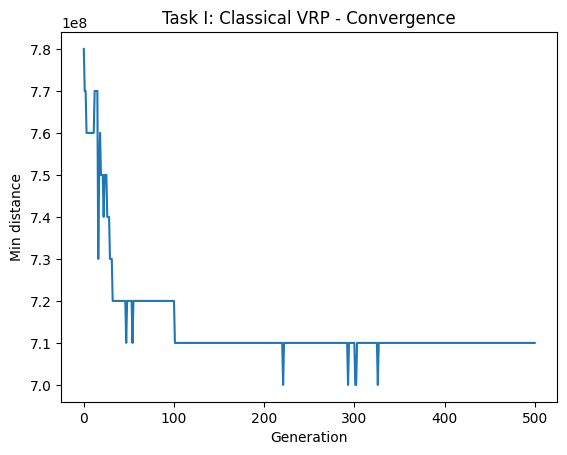

In [20]:
# ---------------------------
# Results
# ---------------------------
best_ind = hof[0]
best_route_customer_ids = [idx_to_cust[i] for i in best_ind]
if task == "I":
    best_distance = eval_vrp_classical(best_ind)[0]
elif task == "II":
    best_distance = eval_vrp_stochastic_singleobj(best_ind)[0]
elif task == "III":
    best_distance = eval_vrp_with_clustering(best_ind)[0]
elif task == "IV":
    best_distance = eval_vrp_multi_weighted(best_ind)
    #best_distance, best_efficiency = eval_vrp_multi_weighted(best_ind)
elif task == "IV-2":
    print(1)
else:
    best_distance = None

print("Best route (customer IDs):", best_route_customer_ids)
print("Best distance:", best_distance)

gen = log.select("gen")
mins = log.select("min")
plt.plot(gen, mins)
plt.xlabel("Generation")
plt.ylabel("Min distance")
if task == "I":
    plt.title("Task I: Classical VRP - Convergence")
elif task == "II":
    plt.title("Task II: Stochastic Demand VRP - Convergence")
elif task == "III":
    plt.title("Task III: Large-scale VRP with Clustering - Convergence")
elif task == "IV":
    plt.title("Task IV: Multi-objective VRP - Convergence")
elif task == "IV-2":
    plt.title("Task IV-2: NSGA - Convergence")
plt.show()
